<a href="https://colab.research.google.com/github/ris0801/DeepLearning/blob/main/Optimizers_in_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

%matplotlib inline

Different optimizers


In [ ]:
class QuadFunc:
  def __init__(self, a, b, c, d, e):
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.e = e

  def getParams(self, x, y):
    if y is None:
      y = x[1]
      x = x[0]
    return x,y

  def __call__(self, x, y=None):
    x,y = self.getParams(x,y)
    return 0.5 * (self.a*x**2 + self.b*y**2) + self.c * x * y + self.d * x + self.e * y

  def grad(self, x, y=None):
    #df/dx = ax + cy + d
    #df/dy = by + cx + e
    x,y = self.getParams(x,y)
    return torch.tensor([self.a * x + self.c * y + self.d, self.b * y + self.c * x + self.e])

  def hess(self, x, y=None):
    #d2f/dx2 = a
    #d2f/dy2 = b
    #d2f/dxdy = c
    #d2f/dydx = c
    x, y = self.getParams(x,y)
    return torch.tensor([[self.a, self.c], [self.c, self.b]])


class GradientDescent:
    def __init__(self, lr=1, b1=0.9, b2=0.999):
        # b1 -> Momentum
        # b2 -> ADAM
        # ADAM Paper -> https://arxiv.org/abs/1412.6980
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param (for Momentum)
        self.b2 = b2 # grad^2 aggregation param (for ADAM)
        
        self.v = 0 # grad aggregation param
        self.w = 0 # grad^2 aggregation param
        self.t = 0
        
        self.eps = 1e-9
        
    def __call__(self, grad,hess):
        
        self.t += 1


        # aggregation
        self.v = self.b1*self.v + (1-self.b1)*grad
        self.w = self.b2*self.w + (1-self.b2)*grad**2
        
        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1
        
        return -1*self.lr*vcorr/(wcorr**0.5 + self.eps)
    
class Newtons:
    # https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    def __init__(self, lr=1):
        self.lr = lr
        
    def __call__(self,grad,hess):
        return -1*self.lr*torch.matmul(torch.inverse(hess), grad)
    
def runOptim(init,optim,func,steps):
    
    curpos = init # current position
    path = [curpos]

    
    for _ in range(steps):        

        grad = func.grad(curpos)
        hess = func.hess(curpos)
            
        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)
    
    return path


def showPath(func,init,paths,labels,colors,levels):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)
    
    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)
    
    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,levels)
    fig.colorbar(cp)
    
    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')
    
    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')
    
    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)

##Gradient Descent 

$f(x,y) = x^2 + y^2$

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


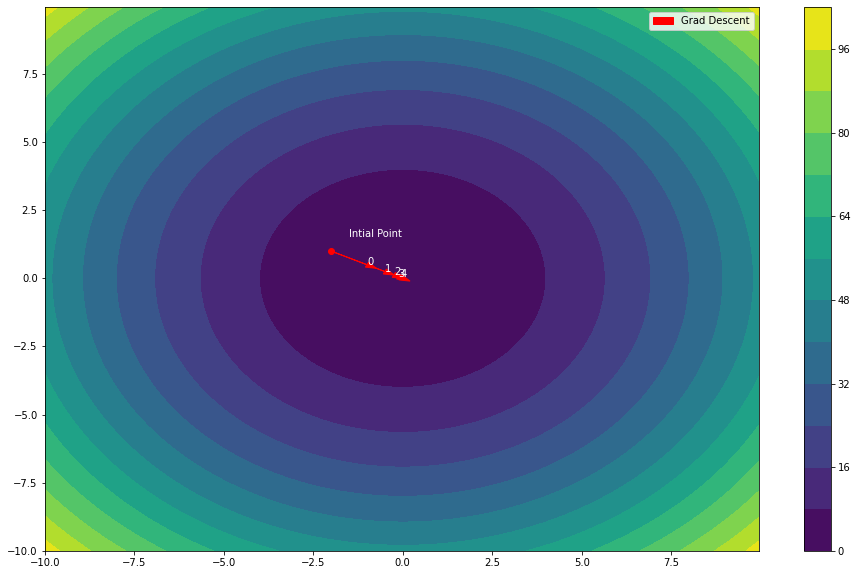

In [ ]:
f = QuadFunc(a=1.0, b=1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, 1.0])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

$f(x,y) = x^2 - y^2$

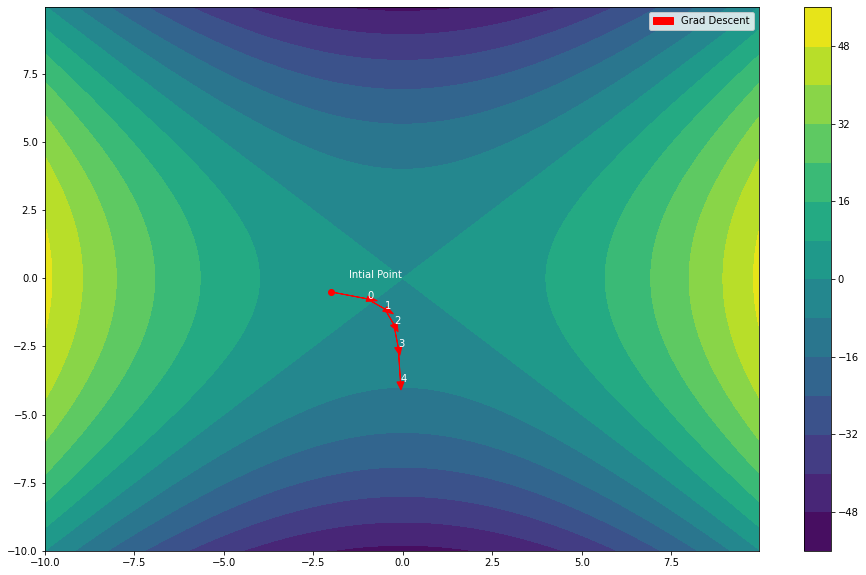

In [ ]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
#try with another starting points
init = torch.tensor([-2.0, -0.5])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

$f(x,y) = x
^2 + y^2 - 0.8*x*y + x +y$

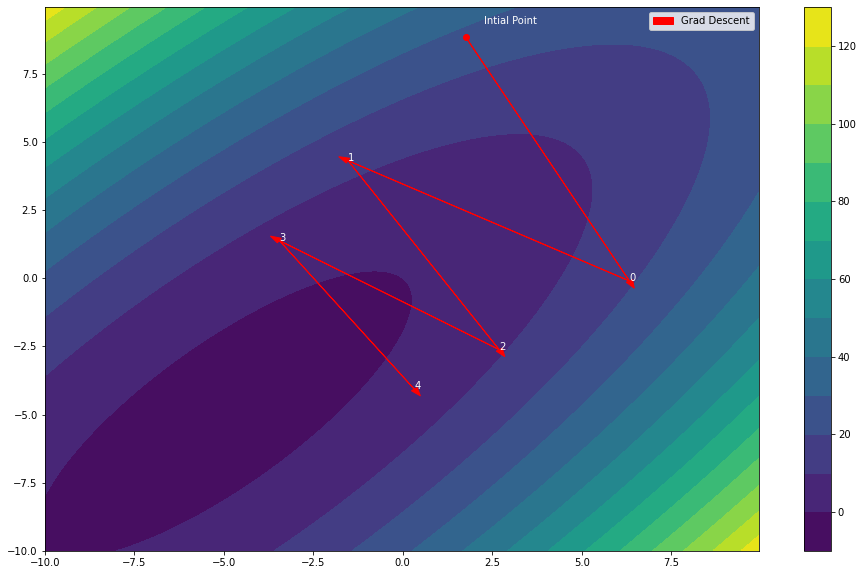

In [ ]:
a = 1/torch.sqrt(torch.tensor(2.0))
ell = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 5 
regGD = GradientDescent(lr=1.5, b1=0, b2=0)
path = runOptim(init, regGD, ell, steps)
showPath(ell, init, [path], ['Grad Descent'], ['r'], 15)

##Newton's Method

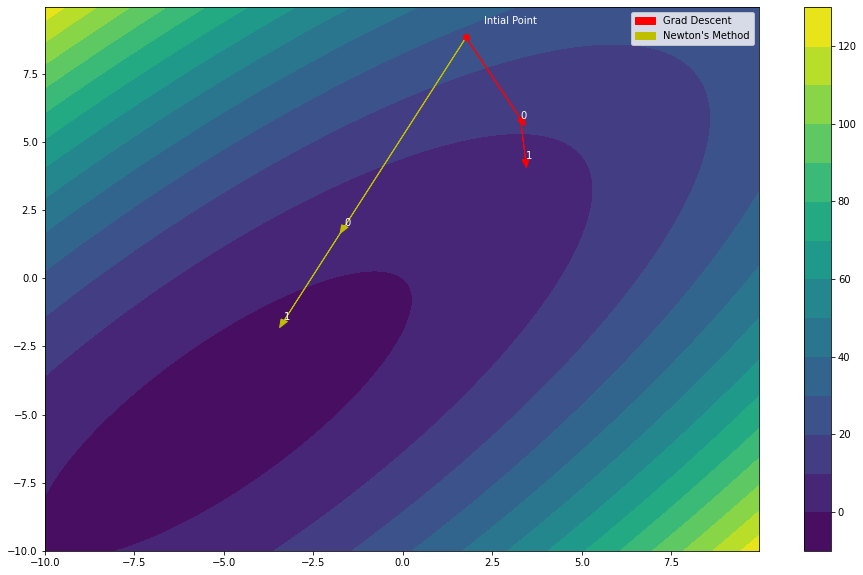

In [ ]:
a = 1/torch.sqrt(torch.tensor(2.0))
ell = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 2 
regGD = GradientDescent(lr=0.5, b1=0, b2=0)
newMT = Newtons(lr=0.5)
path = runOptim(init, regGD, ell, steps)
path2 = runOptim(init, newMT, ell, steps)
showPath(ell, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], 15)

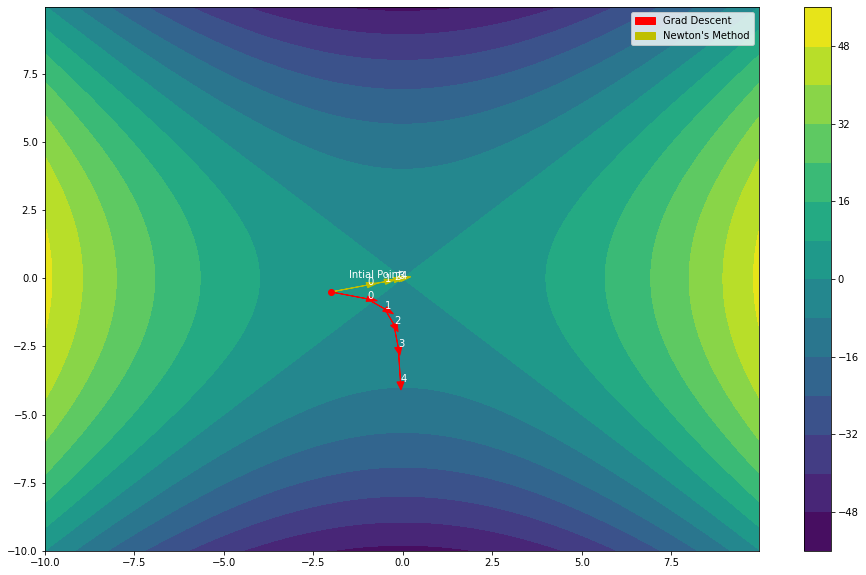

In [ ]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, -0.5])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
newMT = Newtons(lr=0.5)
steps = 5
path = runOptim(init, regGD, f, steps)
path2 = runOptim(init, newMT, f, steps)
showPath(f, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], levels=15)

##Momentum

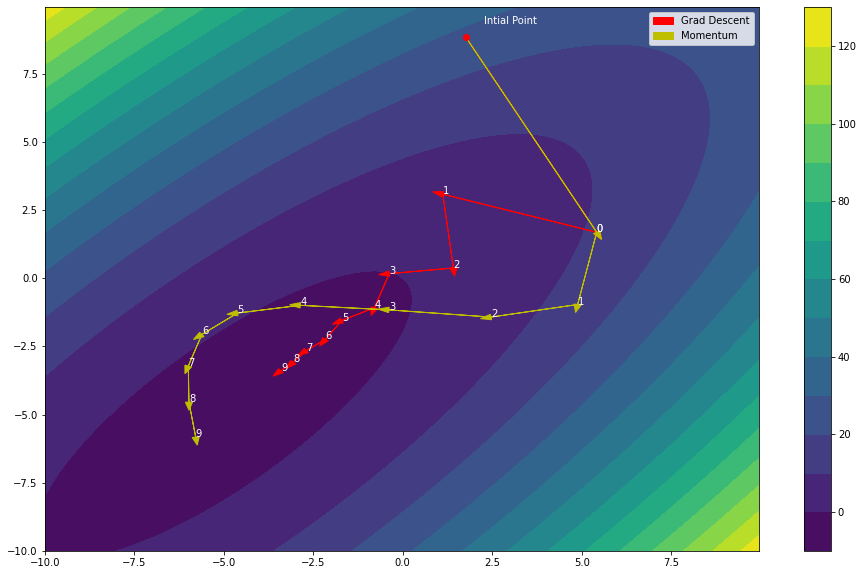

In [ ]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 10
lr = 1.2  
regGD = GradientDescent(lr,0,0) # Without Momentum
momGD = GradientDescent(lr,0.9,0) # Momentum
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
showPath(ell,init,[path1,path2],['Grad Descent','Momentum'],['r','y'], 15)

ADAM

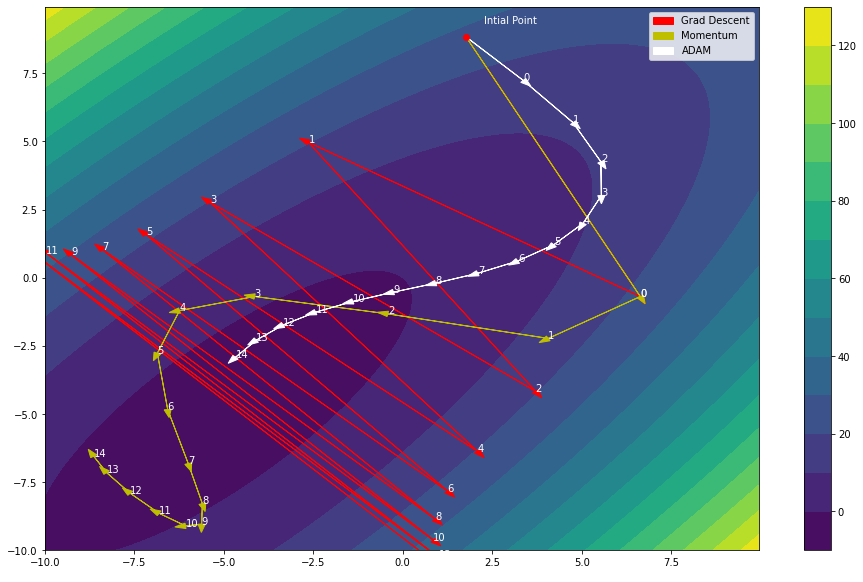

In [ ]:
a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 15
lr = 1.6

regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
path3 = runOptim(init,adamGD,ell,steps)
showPath(ell,init,[path1,path2,path3],['Grad Descent','Momentum','ADAM'],['r','y','w'], 15)
     